In [ ]:
#import needed packages.
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from scipy.fftpack import fft,fftfreq,ifft
from scipy.fftpack import rfft,rfftfreq,irfft

In [71]:
############################################
##functions used by the main routine
############################################

# sta_info_from_inv(inv) is modified from noise_module (with the same name)
#Check NoisePy: https://github.com/mdenolle/NoisePy
def sta_info_from_inv(inv):
    '''
    this function outputs station info from the obspy inventory object
    (used in S0B)
    PARAMETERS:
    ----------------------
    inv: obspy inventory object
    RETURNS:
    ----------------------
    sta: station name
    net: netowrk name
    lon: longitude of the station
    lat: latitude of the station
    elv: elevation of the station
    location: location code of the station
    '''
    # load from station inventory
    sta = inv[0][0].code
    net = inv[0].code
    lon = inv[0][0].longitude
    lat = inv[0][0].latitude
    if inv[0][0].elevation:
        elv = inv[0][0].elevation
    else: elv = 0.

    if inv[0][0][0].location_code:
        location = inv[0][0][0].location_code
    else: location = '00'

    return sta,net,lon,lat,elv,location

#Stolen from NoisePy
def segment_interpolate(sig1,nfric):
    '''
    this function interpolates the data to ensure all points located on interger times of the
    sampling rate (e.g., starttime = 00:00:00.015, delta = 0.05.)
    PARAMETERS:
    ----------------------
    sig1:  seismic recordings in a 1D array
    nfric: the amount of time difference between the point and the adjacent assumed samples
    RETURNS:
    ----------------------
    sig2:  interpolated seismic recordings on the sampling points
    '''
    npts = len(sig1)
    sig2 = np.zeros(npts,dtype=np.float32)

    #----instead of shifting, do a interpolation------
    for ii in range(npts):

        #----deal with edges-----
        if ii==0 or ii==npts-1:
            sig2[ii]=sig1[ii]
        else:
            #------interpolate using a hat function------
            sig2[ii]=(1-nfric)*sig1[ii+1]+nfric*sig1[ii]

    return sig2

# Modified from Zhitu Ma. Modified by Xiaotao Yang
# 1. Reduce input arguments to only read in windown length. Windows will be calculated. 
# 2. Future: Need to revert back to getting windows by excluding earthquakes
# 3. The original code had bugs when computing the admittance and phases. Q and C were not computed.
# 4. The original code hard-coded sample interval when computing the frequencies, which caused wrong
# results if not changed.
def gettransfer(x,y,delta,winlen=2000,iplot=False,figname="debug_transfer.png"):
    """ calculate the transfer function from x to y
    return the coherence, admittance, phase and their corresponding error
    """
    winlen=int(winlen/delta)
    iopt=1
    nsamp=len(x)
    wins=np.arange(0,nsamp-winlen,winlen)
    nd=len(wins)
    ff=np.split(fftfreq(winlen,delta),2)[0]
    
    coh_debug=[]
    win_debug=[]
    taper=scipy.signal.tukey(winlen,0.05)
    for k,win in enumerate(wins):
        xtmp=x[win:win+winlen]
        ytmp=y[win:win+winlen]
        
        x_fft=np.split(fft(taper*xtmp),2)[0]
        y_fft=np.split(fft(taper*ytmp),2)[0]
        if k==0:
            Gxy=np.conj(x_fft)*y_fft
            Gxx=np.conj(x_fft)*x_fft
            Gyy=np.conj(y_fft)*y_fft
            
            Cxy=np.real(x_fft*np.real(y_fft)+np.imag(x_fft*np.imag(y_fft)))
            Qxy=np.real(x_fft*np.imag(y_fft)-np.imag(x_fft*np.real(y_fft)))
        else:
            Gxy=Gxy+np.conj(x_fft)*y_fft
            Gxx=Gxx+np.conj(x_fft)*x_fft
            Gyy=Gyy+np.conj(y_fft)*y_fft
            
            Cxy=Cxy+np.real(x_fft*np.real(y_fft)+np.imag(x_fft*np.imag(y_fft)))
            Qxy=Qxy+np.real(x_fft*np.imag(y_fft)-np.imag(x_fft*np.real(y_fft)))

        cohtmp=np.abs(Gxy)**2/np.real(Gxx)/np.real(Gyy)
        cohtmp=np.sqrt(cohtmp)
        coh_debug.append(np.mean(cohtmp))
        win_debug.append(win)
    
    #normalize by number of windows
    Gxy=Gxy/nd
    Gxx=Gxx/nd
    Gyy=Gyy/nd
    Cxy=Cxy/nd
    Qxy=Qxy/nd
    
#     coh=np.abs(Gxy)**2/np.real(Gxx)/np.real(Gyy)
    coh=np.real(np.abs(Gxy)**2/(Gxx*Gyy))
    coh=np.sqrt(coh)
    if (iopt == 0):
        adm=0.
        phs=0.
        adm_err=0.
        phs_err=0.
    else:
#         adm=np.abs(Gxy)/np.real(Gxx)
        adm=np.real(np.abs(Gxy)/Gxx)
#         phs=np.angle(Gxy) 
        phs=np.arctan(Qxy/Cxy)
        adm_err=np.sqrt(1.-coh**2)/np.abs(coh)/np.sqrt(2*nd)
        coh_err=np.sqrt((1.-coh**2)*np.sqrt(2.0)/np.abs(coh)/np.sqrt(nd))
        phs_err=adm_err
    
    
    if iplot:
        plt.figure(figsize=(8,4))
        plt.plot(win_debug,coh_debug,'o')
        plt.xlabel("window")
        plt.ylabel("coherence")
        plt.title("Debug transfer function")
        plt.savefig(figname,orientation='landscape')
        plt.show()
        plt.close()

    return ff,coh,adm,phs,adm_err,phs_err

# From Zhitu Ma. Modified by Xiaotao Yang
# 1. Use freqmin and freqmax, instead of f1 and f2
# 2. Changed to include the two ending frequencies.
#
def docorrection(tr1,tr2,adm,adm_err,phs,phs_err,freqmin,freqmax,ff,iplot=0):
    """ calculate a quadratic fit to adm and phs
    use this information to predict from tr1, then remove this from tr2
    returning two trace (obspy class), one is the prediction
    one is this prediction removed from tr2 """
    delta=1.0/tr1.stats.sampling_rate
    idx=(ff>=freqmin) & (ff<=freqmax)
    ff_select=ff[idx]
    adm_select=adm[idx]
    adm_err_select=adm_err[idx]
    w=1./adm_err_select
    apol=np.polyfit(ff_select,adm_select,2,w=w)
    phs_select=phs[idx]
    phs_err_select=phs_err[idx]
    w=1./phs_err_select
    ppol=np.polyfit(ff_select,phs_select,2,w=w)
    
    if (iplot==1):
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        adm_fit=apol[0]*ff_select**2+apol[1]*ff_select+apol[2]
        plt.plot(ff_select,adm_select)
        plt.plot(ff_select,adm_fit)
        plt.xlabel("frequency (Hz)")
        plt.ylabel("admittance")
        plt.subplot(1,2,2)
        phs_fit=ppol[0]*ff_select**2+ppol[1]*ff_select+ppol[2]
        plt.plot(ff_select,phs_select)
        plt.plot(ff_select,phs_fit)
        plt.xlabel("frequency (Hz)")
        plt.ylabel("phase shift")
        plt.savefig(tr1.stats.network+"."+tr1.stats.station+"."+tr1.stats.channel+"_"+\
                    tr2.stats.network+"."+tr2.stats.station+"."+tr2.stats.channel+"_adm_phs.png",\
                    orientation='landscape')
        plt.show()
        plt.close()
        
    
    ffr=fftfreq(len(tr1.data),delta)
    tr_pred=tr1.copy()
    tr_left=tr1.copy()
    Htmp_spec=rfft(tr1.data)
    Htmp_spec[0]=0
    Htmp_spec[-1]=0
    for i in np.arange(1,len(ffr)-1,2):
        rp=Htmp_spec[i]
        ip=Htmp_spec[i+1]
        if(ffr[i]>freqmax or ffr[i]<freqmin):
            Htmp_spec[i]=0.
            Htmp_spec[i+1]=0.
            continue
        amp=apol[0]*ffr[i]**2+apol[1]*ffr[i]+apol[2]
        phs=ppol[0]*ffr[i]**2+ppol[1]*ffr[i]+ppol[2]
        c=amp*np.cos(phs)
        d=amp*np.sin(phs)
        Htmp_spec[i]=rp*c-ip*d
        Htmp_spec[i+1]=ip*c+rp*d
    Htmp=irfft(Htmp_spec)
    tr_pred.data=Htmp
    tr_left.data=tr2.data-Htmp
    return tr_pred,tr_left


# Modified from Zhitu Ma. Modified by Xiaotao to get filter frequencies from the arguments
# 1. added titles for multiple plots
# 2. determine freqmax as the Nyquist frequency, if not specified
# 3. Added mode with option to plot overlapping figures.
def plot_trace(tr_list,freqmin=0.02,freqmax=[],size=(10,9),ylabels=[],datalabels=[],\
               title=[],outfile='test.ps',xlimit=[],subplotpar=[],\
              mode="subplot"):
    """
    mode: subplot OR overlap
    """
    plt.figure(figsize=size)
    ntr=len(tr_list)
    if len(subplotpar)==0:
        subplotpar=(ntr,1)
    myymin=[]
    myymax=[]
    for itr,tr in enumerate(tr_list,1):
        tt=tr.times()
        if len(xlimit)>0:
            imin = np.searchsorted(tt,xlimit[0],side="left")
            imax = np.searchsorted(tt,xlimit[1],side="left")
        else:
            imin=0
            imax=len(tr.data)-1
        
        tc=tr.copy()
        
        if freqmax==[]:
            freqmax=0.4999*tr.stats.sampling_rate #slightly lower than the Nyquist frequency
        
        print("station %s.%s, filtered at [%6.3f, %6.3f]" % (tr.stats.network,\
                                                             tr.stats.station,freqmin,freqmax))
        tc.filter('bandpass',freqmin=freqmin,freqmax=freqmax)
        
        if mode=="subplot":
            ax=plt.subplot(subplotpar[0],subplotpar[1],itr)
            plt.plot(tt,tc.data);
            plt.xlabel("time (s)")
            ax.ticklabel_format(axis='x',style='plain')
            if np.max(np.abs(tc.data[imin:imax])) >= 1e+4 or np.max(np.abs(tc.data[imin:imax])) <= 1e-4:
                ax.ticklabel_format(axis='both',style='sci')
            if (len(ylabels)>0):
                plt.ylabel(ylabels[itr-1])
            if len(title)>0:
                plt.title(title[itr-1])
            if len(xlimit)>0:
                plt.xlim(xlimit)
            plt.ylim(0.9*np.min(tc.data[imin:imax]),1.1*np.max(tc.data[imin:imax]))
            plt.text(np.mean(xlimit),0.9*np.max(tc.data[imin:imax]),"["+str(freqmin)+", "+str(freqmax)+"] Hz",\
                     horizontalalignment='center',verticalalignment='center',fontsize=12)
        else:
            if itr==1:ax=plt.subplot(1,1,1)
            plt.plot(tt,tc.data);
            plt.xlabel("time (s)")
            myymin.append(0.9*np.min(tc.data[imin:imax]))
            myymax.append(1.1*np.max(tc.data[imin:imax]))
            if itr==ntr:
                ax.ticklabel_format(axis='x',style='plain')
                ax.legend(datalabels)
                if (len(ylabels)>0):
                    plt.ylabel(ylabels[0])
                if len(title)>0:
                    plt.title(title)
                if len(xlimit)>0:
                    plt.xlim(xlimit)
                plt.ylim(np.min(myymin),np.max(myymax))
                plt.text(np.mean(xlimit),0.85*np.max(myymax),"["+str(freqmin)+", "+str(freqmax)+"] Hz",\
                         horizontalalignment='center',verticalalignment='center',fontsize=14)
    
    plt.savefig(outfile,orientation='landscape')
    plt.show()
    plt.close()

def maxcompfreq(d,iplot=False,figname="waterdepth_maxcompfreq.png"):
    """
    computes the maximum compliance frequency based on eq-11 of Bell et al., BSSA, 2015
    """
#     d=np.arange(1,5051,50) #water depth
    f=np.sqrt(9.8/2/np.pi/d)
    if iplot:
        plt.figure(figsize=(10,5))
        plt.plot(d,f)
        plt.yscale("log")
        plt.grid(which="both")
        plt.xlabel("water depth (m)")
        plt.ylabel("frequency (Hz)")
        plt.text(1.2*np.mean(d),0.5*np.max(f),r'$\sqrt{(\frac{g}{2 \pi d})}$',fontsize=20)
        plt.savefig(figname,orientation='landscape')
        plt.show()
        plt.close()
    
    return f


['J65A', '7D', -125.139603, 47.8913, -165.2, '00']
pressure channel BDH
vertical channel BHZ
resampling from 50 to 20
removing response for 7D.J65A..BHZ | 2012-01-21T00:00:00.000000Z - 2012-01-21T23:59:59.950000Z | 20.0 Hz, 1728000 samples using inv
getting transfer function ...


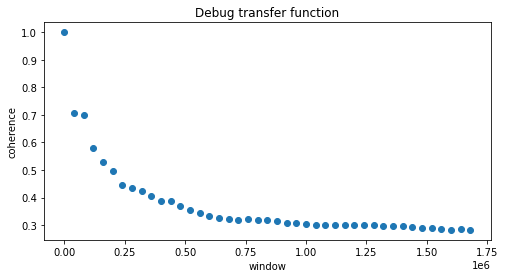

doing correction ...


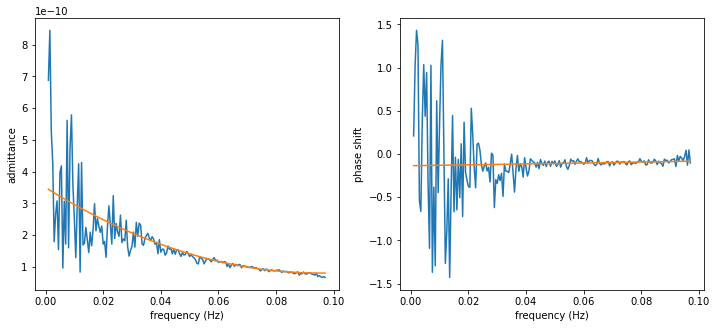

plotting ...
station 7D.J65A, filtered at [ 0.001,  0.097]
station 7D.J65A, filtered at [ 0.001,  0.097]


/usr/local/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:243: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:243: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:243: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:243: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

station 7D.J65A, filtered at [ 0.001,  0.097]
station 7D.J65A, filtered at [ 0.001,  0.097]


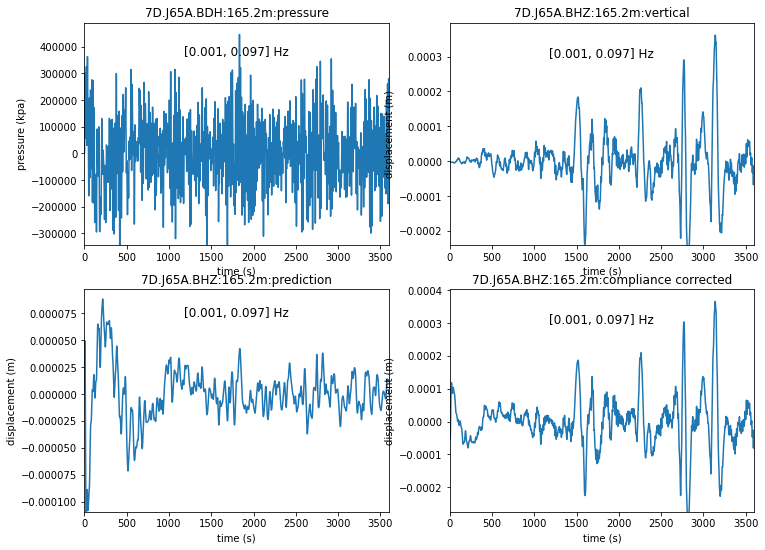

/usr/local/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:243: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:243: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:243: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


station 7D.J65A, filtered at [ 0.001,  0.097]
station 7D.J65A, filtered at [ 0.001,  0.097]
station 7D.J65A, filtered at [ 0.001,  0.097]


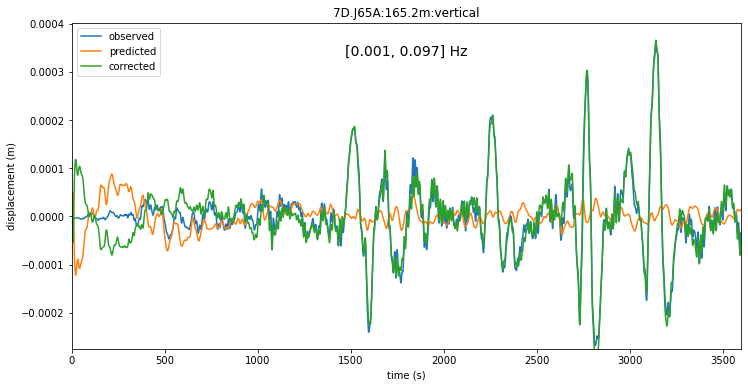

In [73]:
# get data from IRIS web service
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from IPython.display import clear_output

client    = Client('IRIS')
net="7D"
sta=["G03A","J35A","J44A","J65A"]
Pchanlist=["HDH","BDH"] #pressure channels
starttime = obspy.UTCDateTime("2012_01_21_0_0_0")       
endtime   = obspy.UTCDateTime("2012_01_22_0_0_0")
lamin,lamax,lomin,lomax= 37.0,52.0,-133.0,-116.0
rmresp=True #remove instrument response
rmrespoutput="DISP"
# parameters for butterworth filter
samp_freq=20
pfreqmin=0.001
pfreqmax=samp_freq/2

# prefilter information used when removing instrument responses
f1 = 0.9*pfreqmin;f2=pfreqmin
if 1.1*pfreqmax > 0.45*samp_freq:
    f3 = 0.4*samp_freq
    f4 = 0.45*samp_freq
else:
    f3 = pfreqmax
    f4= 1.1*pfreqmax
pre_filt  = [f1,f2,f3,f4]

# get relationship between water depth and maximum compliance frequency.
d=np.arange(1,5051,50) #water depth
f=maxcompfreq(d,iplot=True)

for ista in sta:
    clear_output(wait=True)
    trall=[] 
    stinv=[]
    trlabels=[]
    """
    array to save all four set of traces: 0-pressure, 1-vertical, 2-prediction of vertical from pressure,
    3-corrected vertical
    """
    
    #download pressure data first
    pchanfound=0
    for chan in Pchanlist:
        try:
            sta_invP = client.get_stations(network=net,station=ista,channel=chan,location='*', \
                            starttime=starttime,endtime=endtime,minlatitude=lamin,maxlatitude=lamax, \
                            minlongitude=lomin, maxlongitude=lomax,level='response')
            print()
            pchan=chan
            pchanfound=1
            sta,net,lon,lat,elv,location=sta_info_from_inv(sta_invP)
            print([sta,net,lon,lat,elv,location])
            
            break
        except Exception as e:
            pchanfound == 0
            
    if pchanfound == 0 and chan == Pchanlist[-1]:
        print("Pressure channels not found for "+net+"."+ista)
        continue

    stinv.append(sta_invP)
    trlabels.append(net+"."+ista+"."+pchan+":"+str(np.abs(elv))+"m:pressure")
    tr=client.get_waveforms(network=net,station=ista,\
                    channel=pchan,location="*",starttime=starttime,endtime=endtime)
    trall.append(tr[0])
    print("pressure channel "+pchan)

    #download vertical data now
    zchan=pchan[0]+"HZ"

    sta_invZ = client.get_stations(network=net,station=ista,channel=zchan,location='*', \
                    starttime=starttime,endtime=endtime,minlatitude=lamin,maxlatitude=lamax, \
                    minlongitude=lomin, maxlongitude=lomax,level='response')

    stinv.append(sta_invZ)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:vertical")
    tr=client.get_waveforms(network=net,station=ista,\
                    channel=zchan,location="*",starttime=starttime,endtime=endtime)
    trall.append(tr[0])
    print("vertical channel "+zchan)

    sps=int(trall[0].stats.sampling_rate) #assume pressure and vertical channels have the same sampling rat
    # make downsampling if needed
    if sps > samp_freq:
        # downsampling here
        print("resampling from "+str(sps)+" to "+str(samp_freq))
        for it in range(len(trall)):
            trall[it].interpolate(samp_freq,method='weighted_average_slopes')
            delta = trall[it].stats.delta

            # when starttimes are between sampling points
            fric = trall[it].stats.starttime.microsecond%(delta*1E6)
            if fric>1E-4:
                trall[it].data = segment_interpolate(np.float32(trall[it].data),float(fric/(delta*1E6)))
                #--reset the time to remove the discrepancy---
                trall[it].stats.starttime-=(fric*1E-6)

    #remove response from the two downloaded channels
    if rmresp:
        for it in range(len(trall)):
            if it == 0:continue #skip pressure channel
            if not stinv[it][0][0][0].response:
                raise ValueError('no response found in the inventory! abort!')
            else:
                try:
                    print('removing response for %s using inv'%trall[it])
                    trall[it].attach_response(stinv[it])
                    trall[it].remove_response(output=rmrespoutput,pre_filt=pre_filt,water_level=60)
                except Exception as e:
                    print(e)
                    trall[it] = []
           
    #start compliance correction
    #get the transfer function
    freqmin=pfreqmin
    freqmax=np.around(maxcompfreq(np.abs(elv)),decimals=3)
    delta=1.0/samp_freq
    print("getting transfer function ...")
#     trall[0].data=1000*trall[0].data #change from kpa to pa
    ff,coh,adm,phs,adm_err,phs_err = gettransfer(trall[0].data,trall[1].data,\
                                                 delta,iplot=True,winlen=2000,\
                                                figname=net+"."+ista+"."+pchan+"-"+zchan+"_debug_transfer.png")
    # do correction now.
    print("doing correction ...")
    trZ_pred,trZ_left = docorrection(trall[0],trall[1],adm,adm_err,phs,phs_err,\
                                     freqmin,freqmax,ff,iplot=1)

    trall.append(trZ_pred)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:prediction")
    trall.append(trZ_left)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:compliance corrected")
    
    #plotting
    print("plotting ...")
    tmin=np.max([trall[0].times()[0],trall[1].times()[0]])
    tmax=np.min([trall[0].times()[-1],trall[1].times()[-1]])
    tlen=tmax-tmin
    if tlen>3600:tlen=3600 #only plot 1 hour now
        
    plot_trace(trall,size=(12,9),title=trlabels,freqmin=freqmin,freqmax=freqmax,\
               xlimit=(tmin,tmin+tlen),subplotpar=(2,2),\
               ylabels=["pressure (kpa)","displacement (m)","displacement (m)","displacement (m)"],\
               outfile=net+"."+ista+"_correction.png")
    plot_trace((trall[1],trall[2],trall[3]),size=(12,6),datalabels=["observed","predicted","corrected"],\
               title=net+"."+ista+":"+str(np.abs(elv))+"m:vertical",freqmin=freqmin,freqmax=freqmax,xlimit=(tmin,tmin+tlen),mode="overlap",\
               ylabels=["displacement (m)"],outfile=net+"."+ista+"_comparison.png")

